In [23]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import tensorflow as tf
import cv2

import stylegan_two
from stylegan_two import StyleGAN

In [60]:
stylegan_two.im_size = 128
stylegan_two.directory = "frames/"

class OptimisationEncoder:
    def __init__(self, model, batch_size=16) :
        self.model = model
        self.batch_size = batch_size
        self.steps = [(0.1, 200),(0.05, 100),(0.01, 100),(0.005,100)]
        self.loss_hist = []
        self.batch_size = batch_size
        self.n1 = stylegan_two.noiseList(1)
    
    def _opt_step(self, x1,x2, trunc,target,lr):
        with tf.GradientTape(persistent=True) as g:
            result = self.model.GAN.GMA(stylegan_two.n_layers*[x1] + [x2,trunc])
            loss = tf.reduce_sum(tf.abs(result-target))
        dx2 = g.gradient(loss, x2)
        #x1.assign(x1 - lr * dx1)
        x2.assign(x2 - lr * dx2)
        return loss
    
    def _encode_batch(self, paths) :
        n = len(paths)
        n1 = np.repeat(self.n1[0], n, axis=0)
        x1 = tf.Variable(n1)
        n2 = np.random.uniform(0.0, 1.0, size = [n, stylegan_two.im_size, stylegan_two.im_size, 1]).astype('float32')
        x2 = tf.Variable(n2)
        trunc = tf.ones([1, 1]) * 1.0
        target = []
        for path in paths :
            im = Image.open(path)
            im = im.resize((stylegan_two.im_size, stylegan_two.im_size))
            target.append(im)
        target = tf.constant(np.array(im).astype(np.float32)/255)    
        
        hist = []
        for lr,nb in self.steps :
            for i in range(nb) :
                l = self._opt_step(x1,x2,trunc,target,lr)
                hist.append(l.numpy())
        self.loss_hist.append(hist)
        
        return x2.numpy()
    
    def encode_images(self, paths) :
        i = 0
        res = []
        while i < len(paths) :
            next_i = min(len(paths), i+self.batch_size)
            res.append(self._encode_batch(paths[i:next_i]))
            i = next_i
            print(next_i/len(paths))
        return np.concatenate(res)
    
    def transform(self, lattents) :
        images = []
        trunc = np.ones([1, 1]) * 1.0
        for lattent in lattents :
            n2 = tf.expand_dims(lattent, 0)
            images.append(self.model.GAN.GMA(self.n1 + [n2])[0].numpy())
        return images

In [56]:
model = StyleGAN(lr = 0.0001, silent = False)
model.load(10)

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_84 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
lambda_38 (Lambda)              (None, 1)            0           input_84[0][0]                   
__________________________________________________________________________________________________
dense_77 (Dense)                (None, 1536)         3072        lambda_38[0][0]                  
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 4, 4, 96)     0           dense_77[0][0]                   
___________________________________________________________________________________________

In [61]:
paths = glob.glob('frames/*.jpg')
encoder = OptimisationEncoder(model)

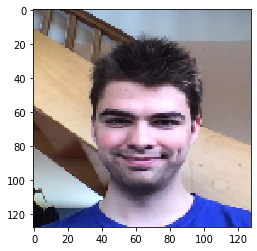

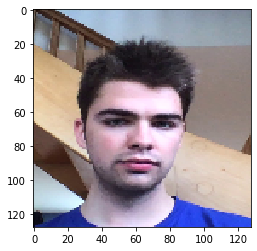

NameError: name 'f' is not defined

In [63]:
res = encoder.encode_images(paths)

In [64]:
images = encoder.transform(res)

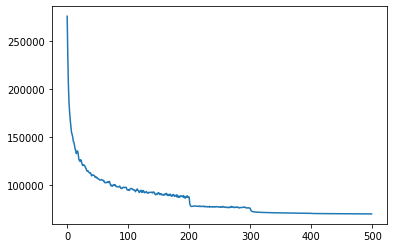

In [7]:
plt.plot(encoder.loss_hist[0])

In [9]:
save_paths = [s.replace("frames", "decoded_frames") for s in paths]

In [21]:
for path, image in zip (save_paths, images) :
    im = Image.fromarray((np.clip(image, 0, 1)*255).astype(np.uint8))
    im.save(path)

In [28]:
img_array = [(np.clip(image, 0, 1)*255).astype(np.uint8) for image in images]
out = cv2.VideoWriter('video.avi',cv2.VideoWriter_fourcc(*'DIVX'), 25, (128,128))
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()